# Quantum. Project 4. Grover's Algorithm

Author:
- ***Nikita Makarevich (Student ID: 153989)***

In [124]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit.quantum_info import Operator
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from dataclasses import dataclass

# selection of quantum simulator (or processor)
backend = Aer.get_backend("qasm_simulator")

STUDENT_ID: int = 153989

In [125]:
def plot_circuit(circuit: QuantumCircuit, *, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111)
    circuit.draw("mpl", ax=ax)
    return ax

def run_experiments(
    backend, circuit: QuantumCircuit, *, shots: int = 2048, runs: int = 3
) -> list[dict]:
    compiled_circuit = transpile(circuit, backend)
    return [
        backend.run(compiled_circuit, shots=shots).result().get_counts()
        for _ in range(runs)
    ]

In [126]:
@dataclass
class Setup:
    n: int
    qx: QuantumRegister
    cx: ClassicalRegister | None
    circuit: QuantumCircuit

    @classmethod
    def create_quantum_only(cls, *, n: int = 3, **circuit_kwargs) -> "Setup":
        qx = QuantumRegister(n, "q")
        circ = QuantumCircuit(qx, **circuit_kwargs)
        return cls(n, qx, None, circ)

    @classmethod
    def create(cls, *, n: int = 3, **circuit_kwargs) -> "Setup":
        qx = QuantumRegister(n, "q")
        cx = ClassicalRegister(n, "c")
        circ = QuantumCircuit(qx, cx, **circuit_kwargs)
        return cls(n, qx, cx, circ)

## 1. Determining the optimal number of repetitions

In [127]:
def convert_to_bits(n: int, a: int) -> str:
    return format(a, f"0{n}b")

In [128]:
def optimal_repetitions(n: int) -> int:
    return int(np.floor(np.pi / 4 * np.sqrt(2**n))) 

## 2. Implementing Grover's Algorithm

In [129]:
def get_phase_oracle_matrix(a_bits: str) -> np.ndarray:
    """Generate the oracle (Uf) matrix for the phase oracle."""

    def _func(x_bits: str) -> int:
        return int(x_bits == a_bits)

    n = len(a_bits)

    matrix = np.eye(2**n, dtype=int)
    for i in range(2**n):
        i_bits = f"{i:0{n}b}"
        x_bits = i_bits
        matrix[i, i] = (-1) ** _func(x_bits)

    return matrix

def get_oracle_as_gate(
    oracle_matrix: np.ndarray, *, n: int, name: str | None = None
) -> Gate:
    """Convert an oracle matrix to a Qiskit Operator gate."""
    oracle_op = Operator(oracle_matrix)

    if not oracle_op.is_unitary():
        raise ValueError("The provided oracle matrix is not unitary.")

    setup = Setup.create_quantum_only(n=n, name=name)
    setup.circuit.append(oracle_op, setup.qx)

    return setup.circuit.to_gate()

In [130]:
def connect_phi_state(setup: Setup) -> None:
    for q in setup.qx:
        setup.circuit.h(q)

def connect_barrier(setup: Setup) -> None:
    """Connect a barrier to the circuit."""
    setup.circuit.barrier(setup.qx)

def connect_diffusion_operator(setup: Setup) -> None:
    """Connect the W diffusion operator to the circuit."""
    for q in setup.qx:
        setup.circuit.h(q)
        setup.circuit.x(q)

    setup.circuit.h(setup.qx[-1])
    setup.circuit.mcx(setup.qx[:-1], setup.qx[-1])
    setup.circuit.h(setup.qx[-1])

    setup.circuit.barrier(setup.qx)

    for q in setup.qx:
        setup.circuit.x(q)
        setup.circuit.h(q)


class GroverCreator:
    def __init__(self, student_id: int) -> None:
        self.student_id = student_id

    def get_a(self, n: int) -> int:
        return (self.student_id % 2**n)

    def get_a_bits(self, n: int) -> str:
        return convert_to_bits(n, self.get_a(n))
        
    def create_grover_setup(self, n: int, s: int | None = None) -> Setup:
        oracle_matrix = get_phase_oracle_matrix(
            self.get_a_bits(n)
        )
        oracle_gate = get_oracle_as_gate(
            oracle_matrix, n=n, name="Uf"
        )
        
        if s is None:
            s = optimal_repetitions(n)

        setup = Setup.create(n=n)

        connect_phi_state(setup)
        connect_barrier(setup)

        for _ in range(s):
            setup.circuit.append(oracle_gate, setup.qx)
            connect_barrier(setup)
            connect_diffusion_operator(setup)
            connect_barrier(setup)

        if setup.cx is not None:
            setup.circuit.measure(setup.qx, setup.cx)

        return setup

    def get_prob_a(self, n: int, s: int | None = None, shots: int = 2048) -> float:
        if s is None:
            s = optimal_repetitions(n)

        grover_setup = self.create_grover_setup(n=n, s=s)
        result = run_experiments(backend, grover_setup.circuit, shots=shots, runs=1)[0]
        prob_a = result.get(self.get_a_bits(n), 0) / shots
        return prob_a

In [131]:
creator = GroverCreator(student_id=STUDENT_ID)

<Axes: >

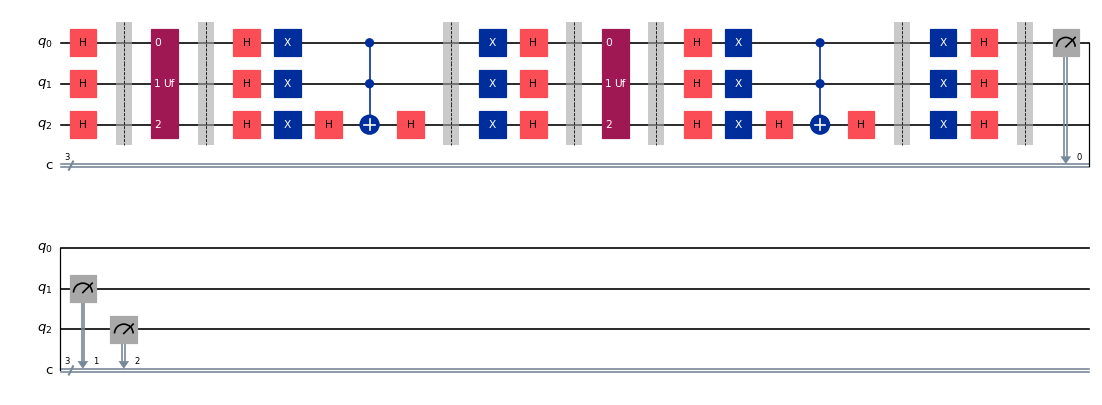

In [132]:
grover_setup = creator.create_grover_setup(n=3)

fig, ax = plt.subplots(figsize=(14,5))
plot_circuit(grover_setup.circuit, ax=ax)

## 3. For $n=6$ and $s=1,...,r$ plot the graph of $p_a(s)$

'a' bits: 000101


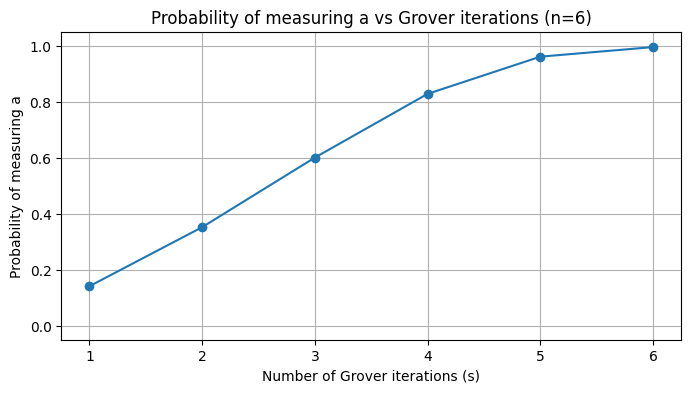

In [133]:
n = 6
r = optimal_repetitions(n)
print(f"'a' bits: {creator.get_a_bits(n)}")

probs_a = [creator.get_prob_a(n=n, s=s) for s in range(1, r+1)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, r+1), probs_a, marker="o")
ax.set_xlabel("Number of Grover iterations (s)")
ax.set_ylabel("Probability of measuring a")
ax.set_title(f"Probability of measuring a vs Grover iterations (n={n})")
ax.set_ylim(0-0.05, 1+0.05)
ax.grid()

## 4. Repeating point (3) for $s=1,..., \lfloor\frac{\pi}{2}\sqrt{2^n}\rfloor$

'a' bits: 000101


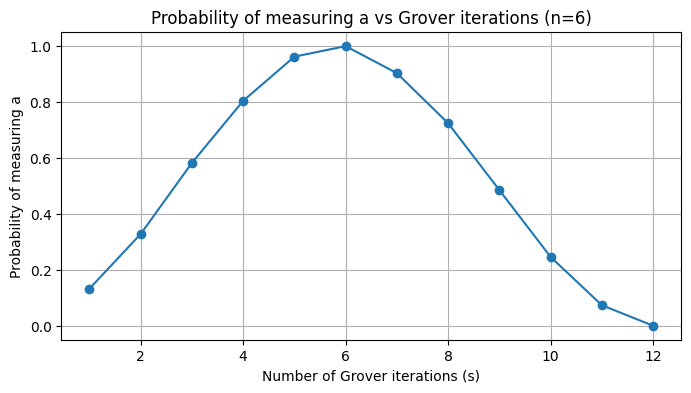

In [134]:
n = 6
print(f"'a' bits: {creator.get_a_bits(n)}")
r = int(np.floor(np.pi / 2 * np.sqrt(2**n)))

probs_a = [creator.get_prob_a(n=n, s=s) for s in range(1, r+1)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, r+1), probs_a, marker="o")
ax.set_xlabel("Number of Grover iterations (s)")
ax.set_ylabel("Probability of measuring a")
ax.set_title(f"Probability of measuring a vs Grover iterations (n={n})")
ax.set_ylim(0-0.05, 1+0.05)
ax.grid()

## 5. For $n=2,...,6$, determing the graph $p_a(n)$ (for optimal number of iterations)

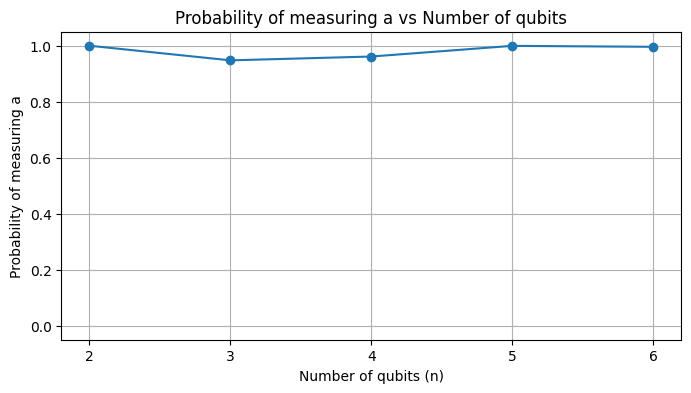

In [135]:
n_vals = list(range(2, 7))
probs_a: list[float] = []

for n in n_vals:
    r = optimal_repetitions(n)
    prob_a = creator.get_prob_a(n=n, s=r)
    probs_a.append(prob_a)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(n_vals, probs_a, marker="o")
ax.set_xlabel("Number of qubits (n)")
ax.set_ylabel("Probability of measuring a")
ax.set_title("Probability of measuring a vs Number of qubits")
ax.set_ylim(0-0.05, 1+0.05)
ax.set_xticks(n_vals)
ax.grid()